In [42]:
import os
import json
import uuid
import numpy as np
import pandas as pd
from pydub import AudioSegment
import librosa

import torch
import torchaudio
from torchvision.models import resnet18
from b2aiprep.process import Audio, specgram, plot_spectrogram, plot_waveform
import IPython.display as Ipd
from torchsummary import summary

In [43]:
active_slot_duration = 5 # in sec
need_complete_audio = False
filter_label = "FIMO" # FIMO, RP, Deep, or empty
label_column = 'status'  # Or 'stridor_status', 'status', 'phonatory_status', depending on your use case
audio_sample_duration = active_slot_duration

# slider information
is_sliding_window_travel = True
travel_frame = 1 # in sec

slot_window_travel = active_slot_duration # in sec
if is_sliding_window_travel:
    slot_window_travel = travel_frame

if need_complete_audio:
    print("No need to split, just add padding")
    if (len(filter_label)):
        if filter_label == "FIMO":
            audio_sample_duration = 13
        elif filter_label == "RP":
            audio_sample_duration = 30
        elif filter_label == "Deep":
            audio_sample_duration = 12
    else:
        audio_sample_duration = active_slot_duration
else:
    print("split into slots, and add padding")
    audio_sample_duration = active_slot_duration

if (len(filter_label)):
    print("some")
else:
    print("noting")

print(f"final audio sample duration: {audio_sample_duration}")

split into slots, and add padding
some
final audio sample duration: 5


In [44]:
from lib import generate_recording_objects, count_samples, filter_recordings_by_label, get_most_active_segment

In [45]:
# Usage
root_path = 'C:\\Users\\namac\\Studies\\B2AI\\STRIDOR FULL ANON-selected\\Data files'  # Replace with the actual path to your folders
excel_path = 'C:\\Users\\namac\\Studies\\B2AI\\Stridor_Labels.xlsx'  # Replace with the actual path to your Excel file
output_csv = 'rec_6_time.csv'  # Desired output CSV file name
output_json = 'rec_6_time.json'  # Desired output JSON file name

# Read the Excel file
patient_status_df = pd.read_excel(excel_path)

recordings = generate_recording_objects(root_path, patient_status_df, label_column)
print(f"Total samples: {len(recordings)}")

# Uncomment the following lines to save to CSV
# save_to_csv(recordings, output_csv)
# print(f"Recording objects have been saved to {output_csv}")

# Uncomment the following lines to save to JSON
# save_to_json(recordings, output_json)
# print(f"Recording objects have been saved to {output_json}")

# Count the samples
no_stridor_count, phonatory_count, non_phonatory_count = count_samples(recordings)
print(f"No-Stridor samples: {no_stridor_count}")
print(f"Phonatory samples: {phonatory_count}")
print(f"Non-Phonatory samples: {non_phonatory_count}")

Total samples: 700
No-Stridor samples: 350
Phonatory samples: 89
Non-Phonatory samples: 261


In [46]:
data = recordings.copy()
print(f"data count: {len(data)}")

# Filter recordings
if (len(filter_label)):
    filtered_data = filter_recordings_by_label(data, filter_label)
    data = filtered_data


print(f"filtered recordings count: {len(data)}")
# print(f"filtered recordings: {data}")

data count: 700
filtered recordings count: 110


In [47]:
# Prepare audio dataset
audio_data = []
for entry in data:
    # Calculate the number of slots and their duration
    row = entry.copy()
    num_slots = int(entry["duration"] // audio_sample_duration)
    
    if num_slots == 0:
        # Audio signal is too short, do padding
        row["uid"] = str(uuid.uuid4())
        row["duration"] = audio_sample_duration
        
        audio = Audio.from_file(entry["recording"])
        audio = audio.to_16khz()
        
        # Pad the signal to match audio_sample_duration
        required_samples = audio_sample_duration * 16000  # 16 kHz sample rate
        padded_signal = torch.nn.functional.pad(audio.signal, (0, required_samples - audio.signal.size(0)), mode='constant', value=0)
        
        row["audio_sample"] = Audio(padded_signal, audio.sample_rate)  # Wrap in Audio class
        
        audio_data.append(row)
    else:
        # Split into smaller parts
        # print(" --- @ --- ")
        required_duration = audio_sample_duration * num_slots
        sr = 16000  # Assuming the sample rate is 16 kHz after resampling
        # print(f"audio_sample_duration: {audio_sample_duration}")
        # print(f"num_slots: {num_slots}")
        # print(f"required_duration: {required_duration}")
        
        # Load the full audio signal
        audio = Audio.from_file(entry["recording"]).to_16khz()
        # print(f"audio: {audio}")
        y = audio.signal
        # print(f"y: {y}")
        y = y.squeeze(1)  # Ensure the tensor has the correct dimensions
        # print(f"y: {y}")
        
        # Get the most active audio signal part for the timeframe of required_duration
        required_samples = required_duration * sr
        active_segment = get_most_active_segment(y, sr, required_samples)
        # print(f"active_segment: {active_segment}")
        
        # Split the active segment into smaller parts of audio_sample_duration
        segment_samples = audio_sample_duration * sr
        # print(f"segment_samples: {segment_samples}")
        segments = [active_segment[i:i + segment_samples] for i in range(0, len(active_segment), segment_samples)]
        # print(f"segments: {segments}")
        
        for i, segment in enumerate(segments):
            if segment.shape[0] < segment_samples:
                padding_needed = segment_samples - segment.shape[0]
                segment = torch.nn.functional.pad(segment, (0, padding_needed))
                # segment = torch.nn.functional.pad(segment, (0, segment_samples - segment.shape[0]), mode='constant', value=0)
            
            segment_audio = Audio(segment.unsqueeze(1), audio.sample_rate)
            
            segment_row = row.copy()
            segment_row["uid"] = f"{entry['uid']}-{i+1}"
            segment_row["duration"] = audio_sample_duration
            segment_row["audio_sample"] = segment_audio
            # print(f'segment_row["audio_sample"]: {segment_row["audio_sample"]}')
            audio_data.append(segment_row)

In [48]:
print(f"audio_data: {len(audio_data)}")

audio_data: 272


In [49]:
class MySpecgramDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_column, num_classes, mel = False):
        self.dataframe = dataframe.copy()  # Copy to avoid modifying the original DataFrame
        self.label_column = label_column
        self.num_classes = num_classes
        self.mel = mel
        
        # Ensure the DataFrame has the necessary columns
        required_columns = ['uid', 'recording_id', 'name', 'recording_label', 'recording', 'audio_sample', label_column]
        for col in required_columns:
            if col not in dataframe.columns:
                raise ValueError(f"DataFrame is missing required column: {col}")
            
         # Store the unique labels and create a mapping
        self.unique_labels = list(self.dataframe[label_column].unique())
        self.label_to_index = {label: index for index, label in enumerate(self.unique_labels)}
        self.index_to_label = {index: label for label, index in self.label_to_index.items()}

        # Convert the label column to integer indices
        self.dataframe[label_column] = self.dataframe[label_column].map(self.label_to_index)

        # Extract necessary information from the DataFrame
        self.audio_files = dataframe['recording'].tolist()
        self.audio_samples = dataframe['audio_sample'].tolist()
        self.labels = self.dataframe[label_column].tolist()
        self.uids = dataframe['uid'].tolist()
        self.recording_labels = dataframe['recording_label'].tolist()
        self.recording_ids = dataframe['recording_id'].tolist()
        self.names = dataframe['name'].tolist()
        # self.num_classes = len(self.unique_labels)
        print(f"self.num_classes: {self.num_classes}")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        uid = self.uids[idx]
        audio_sample = self.audio_samples[idx]
        label = self.labels[idx]
        name = self.names[idx]
        recording_label = self.recording_labels[idx]
        mel = self.mel
        
        # Ensure audio_sample is an instance of Audio
        if not isinstance(audio_sample, Audio):
            raise ValueError(f"Expected audio_sample to be an instance of Audio, but got {type(audio_sample)}")

        # Access the signal and sample_rate attributes
        audio_signal = audio_sample.signal
        sample_rate = audio_sample.sample_rate

        try:
            win_length = 60
            hop_length = 1
            # nfft = int(win_length*16)
            nfft = int(win_length * sample_rate // 1000)
            features_specgram = specgram(audio_sample, win_length=win_length, hop_length=hop_length, n_fft=nfft).T
            
            if mel:
                # mel_transform = torchaudio.transforms.MelScale(n_mels=50, sample_rate=16000, n_stft=481)
                # mel_spec = mel_transform(features_specgram.unsqueeze(0)).squeeze(0)
                # mel_spec = 10.0 * torch.log10(torch.maximum(mel_spec, torch.full(mel_spec.size(), fill_value=1e-10)))
                # features_specgram = mel_spec
                mel_transform = torchaudio.transforms.MelScale(n_mels=50, sample_rate=16000, n_stft=nfft//2 + 1)
                mel_spec = mel_transform(features_specgram.unsqueeze(0)).squeeze(0)
                mel_spec = 10.0 * torch.log10(torch.maximum(mel_spec, torch.full(mel_spec.size(), fill_value=1e-10)))
                features_specgram = mel_spec
            else:
                features_specgram = 10.0 * torch.log10(torch.maximum(features_specgram, torch.full(features_specgram.size(), fill_value=1e-10)))

            features_specgram = torch.nn.functional.interpolate(features_specgram.unsqueeze(0).unsqueeze(0), size=(512, 512), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)

        except Exception as e:
            print(f"Error while converting audio signal with uid: {uid}, name: {name}, recording_label: {recording_label}: {e}")
            return self.__getitem__((idx + 1) % len(self))

        # # Convert the label to a tensor
        # label = torch.tensor(label, dtype=torch.float32)
        
        # Convert the label to a one-hot encoded tensor
        label_tensor = torch.tensor(label, dtype=torch.long)
        label_tensor = torch.nn.functional.one_hot(label_tensor, num_classes=self.num_classes).float()

        # return {'uid': uid, 'signal': features_specgram, 'audio': audio_sample.signal, self.label_column: label_tensor, 'recording_label': recording_label}
        return {'uid': uid, 'signal': features_specgram, 'audio': audio_signal, self.label_column: label_tensor, 'recording_label': recording_label}
    
    def decode_label(self, label_tensor):
        """
        Decode a one-hot or integer label tensor back to its original categorical label.
        """
        if label_tensor.dim() == 1 and label_tensor.size(0) == self.num_classes:
            # One-hot encoded tensor
            label_index = torch.argmax(label_tensor).item()
        elif label_tensor.dim() == 0:
            # Integer tensor
            label_index = label_tensor.item()
        else:
            raise ValueError("Unsupported label tensor format")
        
        return self.index_to_label[label_index]

In [50]:
import matplotlib.pyplot as plt
import IPython.display as ipd

def display_and_play_sample(audio_data, index):
    if index < 0 or index >= len(audio_data):
        print("Index out of range")
        return

    sample = audio_data[index]
    audio_signal = sample["audio_sample"].signal.squeeze().numpy()  # Extract signal from Audio object and convert to numpy array
    sample_rate = sample["audio_sample"].sample_rate  # Get the sample rate from the Audio object
    
    # Display details
    print(f"UID: {sample['uid']}")
    print(f"Recording ID: {sample['recording_id']}")
    print(f"Recording Label: {sample['recording_label']}")
    
    # Plot waveform
    plt.figure(figsize=(12, 4))
    plt.plot(audio_signal)
    plt.title("Waveform")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.show()
    
    # Play audio
    ipd.display(ipd.Audio(audio_signal, rate=sample_rate))

UID: 2c9c051e-8ec4-4888-8d9e-9b95a3204965-1
Recording ID: 2c9c051e-8ec4-4888-8d9e-9b95a3204965
Recording Label: FIMO12inch


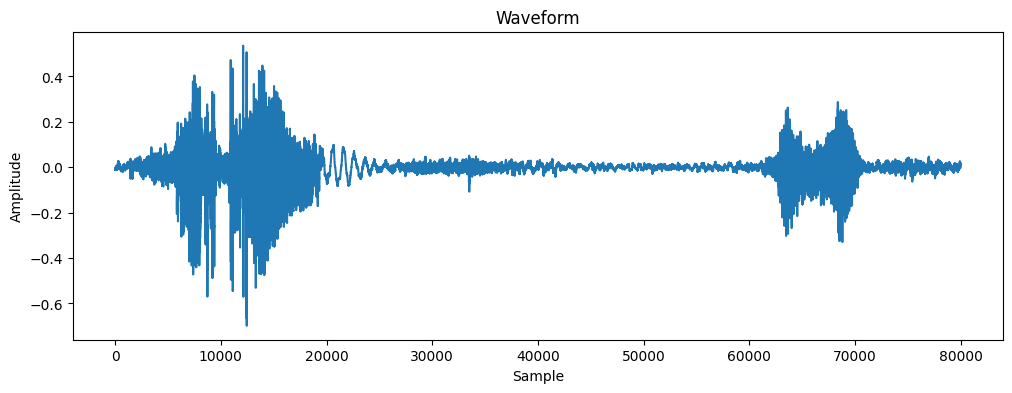

In [51]:
# Example usage
index = 4  # Replace with the desired sample index
display_and_play_sample(audio_data, index)

num_classes: 3
self.num_classes: 3
dataset: <__main__.MySpecgramDataset object at 0x0000022533EBAFF0>
['FIMOAvid', 'FIMOiPad', 'FIMOAvid', 'FIMOavid', 'FIMOiPad', 'FIMOAvid', 'FIMOiPad', 'FIMOiPad'] tensor([[1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
the shape is:  torch.Size([512, 512])
the size is:  torch.Size([8, 512, 512])


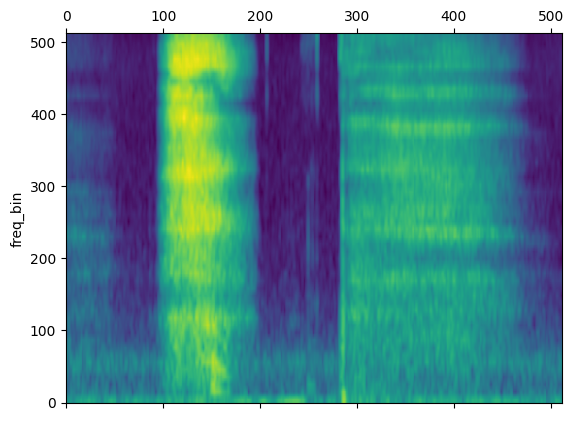

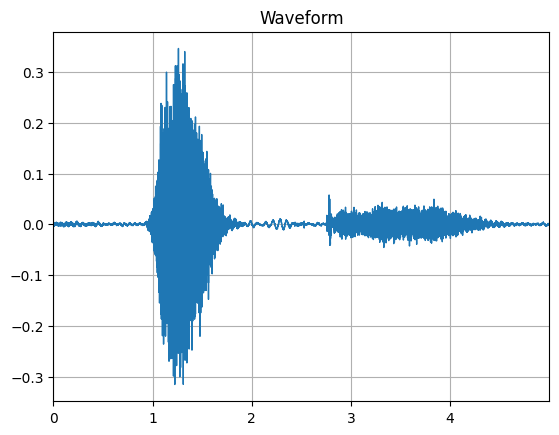

In [52]:
# convert into dataframe
df = pd.DataFrame(audio_data)
# print(f"df: {df}")
num_classes = df[label_column].nunique()
print(f"num_classes: {num_classes}")

dataset = MySpecgramDataset(df, label_column, num_classes, mel = True)
print(f"dataset: {dataset}")

# # Example: Iterate through the dataset
# for i in range(len(dataset)):
#     sample = dataset[i]
#     print(sample['recording_label'], sample[label_column])

# # Example: Decode a label
# sample_label = dataset[22][label_column]
# print(f"sample_label: {sample_label}")
# decoded_label = dataset.decode_label(sample_label)
# print(f"Original label: {decoded_label}")

# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for batching and shuffling
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

# Example: Iterate through the train DataLoader
for batch in train_dataloader:
    print(batch['recording_label'], batch[label_column])
    plot_spectrogram(batch['signal'][0])
    plot_waveform(batch['audio'][0], 16000, title="Waveform", ax=None)
    # for i in range(1,2):
    #     plot_spectrogram(batch['signal'][i])
    #     plot_waveform(batch['audio'][i], 16000, title="Waveform", ax=None)
    print("the shape is: ", batch['signal'][0].shape)
    print("the size is: ", batch['signal'].shape)
    break

In [53]:
cnn = resnet18('IMAGENET1K_V1')
cnn.fc = torch.nn.Linear(512, num_classes)
_ = summary(cnn, (3, 257, 301))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 129, 151]           9,408
       BatchNorm2d-2         [-1, 64, 129, 151]             128
              ReLU-3         [-1, 64, 129, 151]               0
         MaxPool2d-4           [-1, 64, 65, 76]               0
            Conv2d-5           [-1, 64, 65, 76]          36,864
       BatchNorm2d-6           [-1, 64, 65, 76]             128
              ReLU-7           [-1, 64, 65, 76]               0
            Conv2d-8           [-1, 64, 65, 76]          36,864
       BatchNorm2d-9           [-1, 64, 65, 76]             128
             ReLU-10           [-1, 64, 65, 76]               0
       BasicBlock-11           [-1, 64, 65, 76]               0
           Conv2d-12           [-1, 64, 65, 76]          36,864
      BatchNorm2d-13           [-1, 64, 65, 76]             128
             ReLU-14           [-1, 64,

In [54]:
# Function to evaluate the model
def eval(model, dataloader):
    model.eval()
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            bs, h, w = batch['signal'].shape
            inputs = batch['signal'].unsqueeze(1).expand(bs, 3, h, w)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            total_correct += (preds == torch.argmax(batch[label_column], 1)).sum().item()
            total_samples += bs
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(torch.argmax(batch[label_column], 1).cpu().numpy())
    
    accuracy = total_correct / total_samples
    return accuracy, all_preds, all_labels	

# Training the model
num_epochs = 10
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001, weight_decay=5e-5)

best_val_acc = 0
for epoch in range(num_epochs):
    cnn.train()
    
    train_loss = 0
    total_train_samples = 0
    for batch in train_dataloader:
        bs, h, w = batch['signal'].shape
        inputs = batch['signal'].unsqueeze(1).expand(bs, 3, h, w)

        optimizer.zero_grad()
        outputs = cnn(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, torch.argmax(batch[label_column], 1))
        train_loss += loss.item() * bs
        total_train_samples += bs
        loss.backward()
        optimizer.step()
    
    train_loss /= total_train_samples
    train_acc, _, _ = eval(cnn, train_dataloader)
    val_acc, _, _ = eval(cnn, val_dataloader)
    
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train ACC: {train_acc:.4f}, Val ACC: {val_acc:.4f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(cnn.state_dict(), './my_resnet_model.pth')
        print('Saved!')

Error while converting audio signal with uid: bb0d6f15-b88b-4ca8-bab4-185020473cda, name: Patient 34, recording_label: FIMOAvid: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 43858414080 bytes.
Epoch: 1, Train Loss: 1.1514, Train ACC: 0.4608, Val ACC: 0.3333
Saved!
Error while converting audio signal with uid: bb0d6f15-b88b-4ca8-bab4-185020473cda, name: Patient 34, recording_label: FIMOAvid: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 43858414080 bytes.
Epoch: 2, Train Loss: 0.8726, Train ACC: 0.2811, Val ACC: 0.1852
Error while converting audio signal with uid: bb0d6f15-b88b-4ca8-bab4-185020473cda, name: Patient 34, recording_label: FIMOAvid: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 43858414080 bytes.
Epoch: 3, Train Loss: 0.8416, Train ACC: 0.5300, Val ACC: 0.3704
Saved!
Error while converting audio signal

KeyboardInterrupt: 

In [ ]:
# Load the best model and evaluate on the test set
cnn.load_state_dict(torch.load('./my_resnet_model.pth'))
test_acc, test_preds, test_labels = eval(cnn, test_dataloader)
print(f'Test Accuracy: {test_acc:.4f}')

Error while converting audio signal with uid: cf9b2713-f794-4e93-9ca7-876854db0983, name: Patient 34, recording_label: FIMOAvid: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 43858414080 bytes.
Test Accuracy: 0.8750


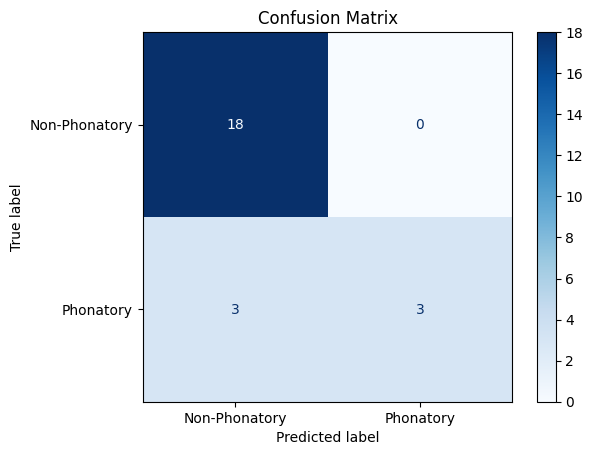

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.unique_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()